In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

In [2]:
gdf = gpd.read_file(".\shapefile\quads3310-20131231.shp")

print(gdf.head())

       ID  SPECIES_ID  QUAD_ID                  SPECIES          QUAD_NAME  \
0  552874         101      514  Zantedeschia aethiopica       CALNEVA LAKE   
1  552875         101      639  Zantedeschia aethiopica            CALPINE   
2  552876         101     2319  Zantedeschia aethiopica       CALUMET MINE   
3  552877         101     2360  Zantedeschia aethiopica  CALUMET MOUNTAINS   
4  552878         101     1748  Zantedeschia aethiopica    CALVADA SPRINGS   

   ABUNDANCE  SPREAD                  ABUNSPREAD   MANAGEMENT        DATE  \
0          0       0  Suspected absent from quad  not managed  2011-06-27   
1          0       0  Suspected absent from quad  not managed  2011-06-27   
2          0       0  Suspected absent from quad  not managed  2011-09-13   
3          0       0  Suspected absent from quad  not managed  2011-09-13   
4          0       0  Suspected absent from quad  not managed  2011-06-30   

  SOURCE                                         PARTICIPAN OBS_NOTE

In [3]:
weeds = gdf[['ID', 'SPECIES_ID', 'QUAD_ID', 'ABUNDANCE',
       'SPREAD', 'DATE', 'geometry']]

weeds = weeds[weeds['ABUNDANCE'] != 9] #Remove species which couldn't be properly identified

print(f"Num Species: {len(list(set(weeds['SPECIES_ID'])))}, Num Reigons: {len(list(set(weeds['QUAD_ID'])))}")

Num Species: 265, Num Reigons: 2856


Text(0.5, 1.0, 'Species Distribution Across Quads')

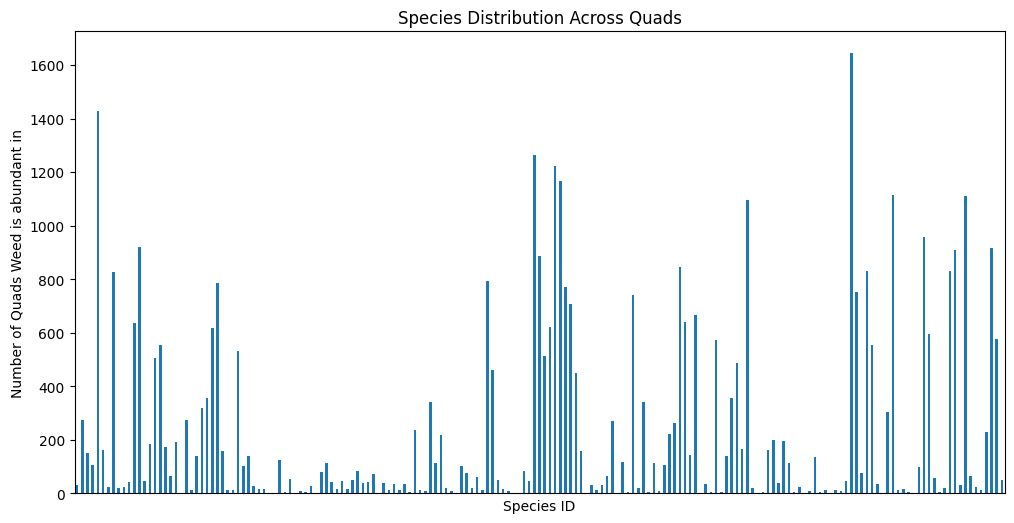

In [5]:
# Group by species_id and count number of unique quad_ids
species_quad = weeds[weeds["ABUNDANCE"] > 1].groupby("SPECIES_ID")["QUAD_ID"].nunique()

# Plot bar chart
plt.figure(figsize=(12, 6))
species_quad.plot(kind="bar")
plt.xticks([], []) 
plt.xlabel("Species ID")
plt.ylabel("Number of Quads Weed is abundant in")
# plt.yscale("log")
plt.title("Species Distribution Across Quads")

In [9]:
california = gpd.read_file(".\shapefile\CA_State.shp")
california = california.to_crs(epsg = 3857)
fires = gpd.read_file(".\shapefile\Perimeters.shp")
fires = fires[fires.is_valid]
fires = fires.to_crs(epsg = 3857)

<Axes: >

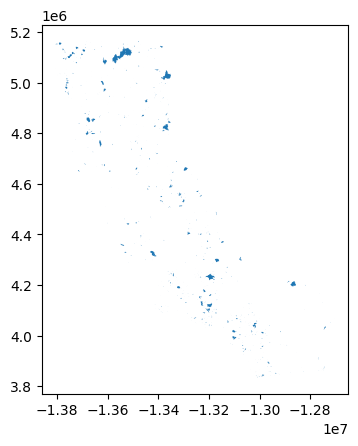

In [10]:
intersection = gpd.sjoin(fires, california, how='inner')

intersection.plot()

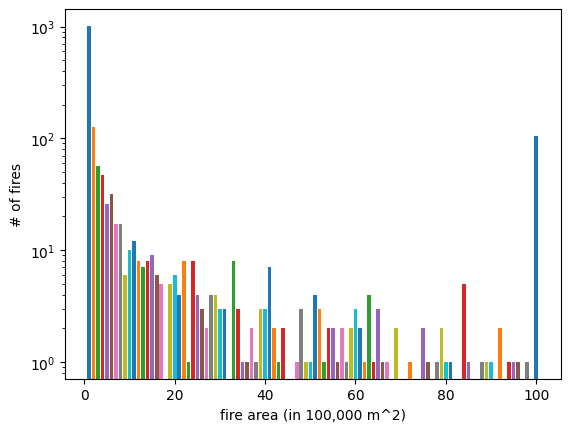

In [39]:
intersection["area"] = intersection.geometry.area


reigons = [i*(100000) for i in range(101)]


for i in range(1, 101):
    plt.bar(i, len(intersection[intersection["area"]<=reigons[i]][intersection["area"]>reigons[i-1]]))
plt.bar(i, len(intersection[intersection["area"]>reigons[-1]]))

plt.xlabel("fire area (in 100,000 m^2)")
plt.ylabel("# of fires")
plt.yscale("log")
plt.show()

In [11]:
#For each weed, if a fire was in a quad and the weed was in a quad, +1
weeds_by_species = weeds[weeds["ABUNDANCE"] > 1].to_crs(intersection.crs)

for i in range(len(intersection)):
    weeds_by_species[f"intersects_target {i}"] = weeds_by_species.geometry.intersects(intersection.geometry.iloc[i]).astype(int)

In [36]:
weeds_by_species["fires"] = weeds_by_species[[f"intersects_target {i}" for i in range(len(intersection))]].sum(axis = 1)

# print(sum(weeds_by_species[weeds_by_species["SPECIES_ID"] == 1]["fires"]))

species_fire_count = [sum(weeds_by_species[weeds_by_species["SPECIES_ID"] == i]["fires"]) for i in list(set(weeds_by_species["SPECIES_ID"]))]

In [37]:
species_fire_count[0]

19

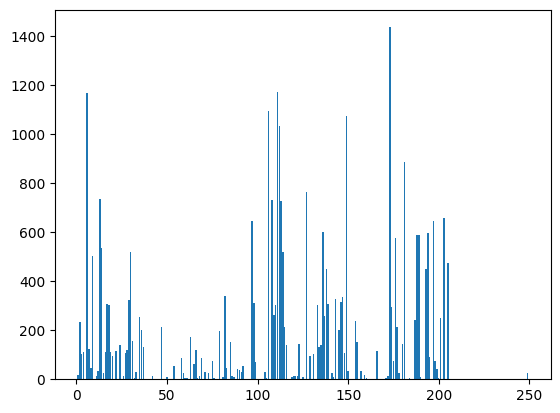

In [38]:

plt.bar(list(set(weeds_by_species["SPECIES_ID"])), species_fire_count)
plt.show()

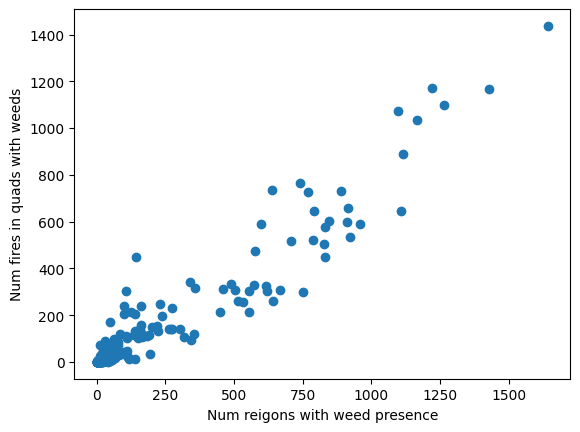

In [39]:
plt.scatter(species_quad,species_fire_count)
plt.xlabel("Num reigons with weed presence")
plt.ylabel("Num fires in quads with weeds")
plt.show()